In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from pathlib import Path
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy import signal
from dataclasses import dataclass
from collections import namedtuple
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from astroML.correlation import two_point
from scipy.interpolate import interp1d
from pysep.dsep import load_model

In [2]:
@dataclass
class colorscheme:
    DartmouthGreen : str = "#00693E"
    ForestGreen : str = "#12312B"
    RichForestGreen : str = "#0D1E1C"
    White : str = "#FFFFFF"
    Black : str = "#000000"
    AutumBrown : str = "#643C20"
    BonfireRed : str = "#9D162E"
    SpringGreen : str = "#C4DD88"
    Violet : str = "#B607DE"
    
    pallet = namedtuple("pallet", "C0 C1")
    primary : namedtuple = pallet(DartmouthGreen, Black)
    seconday : namedtuple = pallet(ForestGreen,AutumBrown)
    tertiery : namedtuple = pallet(RichForestGreen,BonfireRed)

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [4]:
def load_data(path):
    data = dict()
    for filepath in Path(path).rglob("*.out"):
        age = float(str(filepath).split('/')[-2][:-3])
        if age not in data:
            data[age] = dict()
        dt = np.loadtxt(filepath, delimiter=',')
        num = dt.shape[0]
        data[age][num] = dt
    return data

In [5]:
def get_bin_density(arr, binSize, axis=0):
    startPositions = np.arange(arr[axis].min(), arr[axis].max(), binSize)
    densities = np.zeros_like(startPositions)
    centers = np.zeros_like(startPositions)
    for idx, startPosition in enumerate(startPositions):
        nextPosition = startPosition + binSize
        subArr = arr[:, (arr[axis] >= startPosition) & (arr[axis] < nextPosition)]
        density = subArr.shape[1]/binSize
        densities[idx] = density
        centers[idx] = (nextPosition+startPosition)/2
    return densities, centers

In [6]:
def plot_CMD(data, ax=None, bounds=None, po=True,kde_b=True,fmt="k.",kdealpha=1,poalpha=1):
    G = data[:, 6]
    BP = data[:, 7]
    RP = data[:, 8]

    BPRP = BP-RP

    if not bounds:
        xmin = np.min(BPRP)
        xmax = np.max(BPRP)
        ymin = np.min(G)
        ymax = np.max(G)
    else:
        xmin = bounds[0][0]
        xmax = bounds[0][1]
        ymin = bounds[1][0]
        ymax = bounds[1][1]
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    kde = gaussian_kde(np.vstack((BPRP, G)))
    Z = np.reshape(kde(positions).T, X.shape)

    mult = False

    if not ax:
        fig, axs = plt.subplots(1, 2, figsize=(10, 7))
        mult=True
    else:
        if isinstance(ax, np.ndarray):
            mult = True
            axs = ax

    if mult:
        imax = axs[0]
    else:
        imax = ax
    if kde_b:
        norm=plt.Normalize(Z.min(),Z.max())
        cmap = LinearSegmentedColormap.from_list("", [colorscheme.White,colorscheme.SpringGreen, colorscheme.primary.C0,colorscheme.seconday.C0])
        imax.imshow(np.rot90(Z), cmap=cmap,
                  extent=[xmin, xmax, ymin, ymax],aspect='auto',alpha=kdealpha)

    if mult:
        axs[1].plot(BP - RP, G, fmt,alpha=poalpha)
    if not mult and po:
        imax.plot(BP - RP, G, fmt,alpha=poalpha)
    # imax.invert_yaxis()
    # if mult:
    #     axs[1].invert_yaxis()
    
    if bounds:
        imax.set_xlim(bounds[0][0],bounds[0][1])
        imax.set_ylim(bounds[1][0],bounds[1][1])
    if not ax:
        return fig, axs, kde
    else:
        return kde

In [26]:
def Kippenhan_Iben(age, radius, convectiveMask, ageTrk, Teff, L, R, He3):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    axes = [ax, ax.twinx(), ax.twinx(), ax.twinx(), ax.twinx()]
    # fig.subplots_adjust(right=0.75)

    axes[2].spines['right'].set_position(('axes', 1.6))
    axes[3].spines['right'].set_position(('axes', 1.4))
    axes[4].spines['right'].set_position(('axes', 1.2))

    axes[2].set_frame_on(True)
    axes[2].patch.set_visible(False)
    axes[3].set_frame_on(True)
    axes[3].patch.set_visible(False)
    axes[4].set_frame_on(True)
    axes[4].patch.set_visible(False)

    colors = (colorscheme.DartmouthGreen, colorscheme.Violet, colorscheme.BonfireRed, colorscheme.AutumBrown)
    axes[0].pcolormesh(age, radius, convectiveMask.T, hatch='/', cmap=mpl.cm.get_cmap('binary_r'))
    axes[0].set_xlabel('Age [Gyr]', fontsize=27)
    axes[0].set_ylabel('Radius Fraction', fontsize=27)

    axes[1].plot(ageTrk, Teff, color=colors[0])
    axes[1].set_ylabel(r'Log[$T_{core}$]', fontsize=27, color=colors[0])
    axes[1].tick_params(axis='y', colors=colors[0])

    axes[2].plot(ageTrk, L, color=colors[1])
    axes[2].set_ylabel(r'L/L$_{ZAMS}$', fontsize=27, color=colors[1])
    axes[2].tick_params(axis='y', colors=colors[1])

    axes[3].plot(ageTrk, R, color=colors[2])
    axes[3].set_ylabel(r'R/R$_{ZAMS}$', fontsize=27, color=colors[2])
    axes[3].tick_params(axis='y', colors=colors[2])

    axes[4].plot(ageTrk, He3, color=colors[3])
    axes[4].set_ylabel(r'X($^{3}$He)$_{core}$', fontsize=27, color=colors[3])
    axes[4].tick_params(axis='y', colors=colors[3])
    
    for ax in axes:
        ax.tick_params('both', length=12, width=1, which='major')
        ax.tick_params('both', length=6, width=1, which='minor')
        ax.tick_params(axis='x',labelsize=27)
        ax.tick_params(axis='y',labelsize=27)

    return fig, axes

In [18]:
def mkKippenhan(model, filename="Figures/Kippenhan.pdf"):
    binMod = model.mod()
    headers = binMod['header']
    cards = binMod['cards']
    trk = model.trk()

    minAge = 0.1
    maxAge = 12

    age = headers[:, 1]
    ageMask = age[(age <= maxAge) & (age >= minAge)]

    trkAgeCond = (trk['AGE'] <= maxAge) & (trk['AGE'] >= minAge)
    trkAge = trk['AGE'][trkAgeCond]

    ClogT = trk['C_log_T']
    Teff = ClogT[trkAgeCond]

    LLZAMS = ((10**trk['log_L'])/(10**trk.iloc[0]['log_L']))[trkAgeCond]

    RRZAMS = ((10**trk['log_R'])/(10**trk.iloc[0]['log_R']))[trkAgeCond]

    He3 = trk['CA_He3'][trkAgeCond]


    convectiveMask = cards[:, 5, :]
    radius = np.linspace(0, 1, convectiveMask.T.shape[0])

    radiusCut = 0.05

    convectiveMaskF = convectiveMask[(age <= maxAge) & (age >= minAge)]
    convectiveMaskF = convectiveMaskF[:,radius < radiusCut]

    fig, axes = Kippenhan_Iben(ageMask, radius[radius < radiusCut], convectiveMaskF, trkAge, Teff, LLZAMS, RRZAMS, He3)

    fig.savefig(filename, bbox_inches="tight")

In [7]:
opal_path = "/mnt/Astronomy/GraduateSchool/Thesis/JaoOpacity/ext_data/ClampedAgeRun_OPAL/"
tops_path = "/mnt/Astronomy/GraduateSchool/Thesis/JaoOpacity/ext_data/ClampedAgeRun_TOPS/"

In [8]:
data_opal = load_data(opal_path)
data_tops = load_data(tops_path)

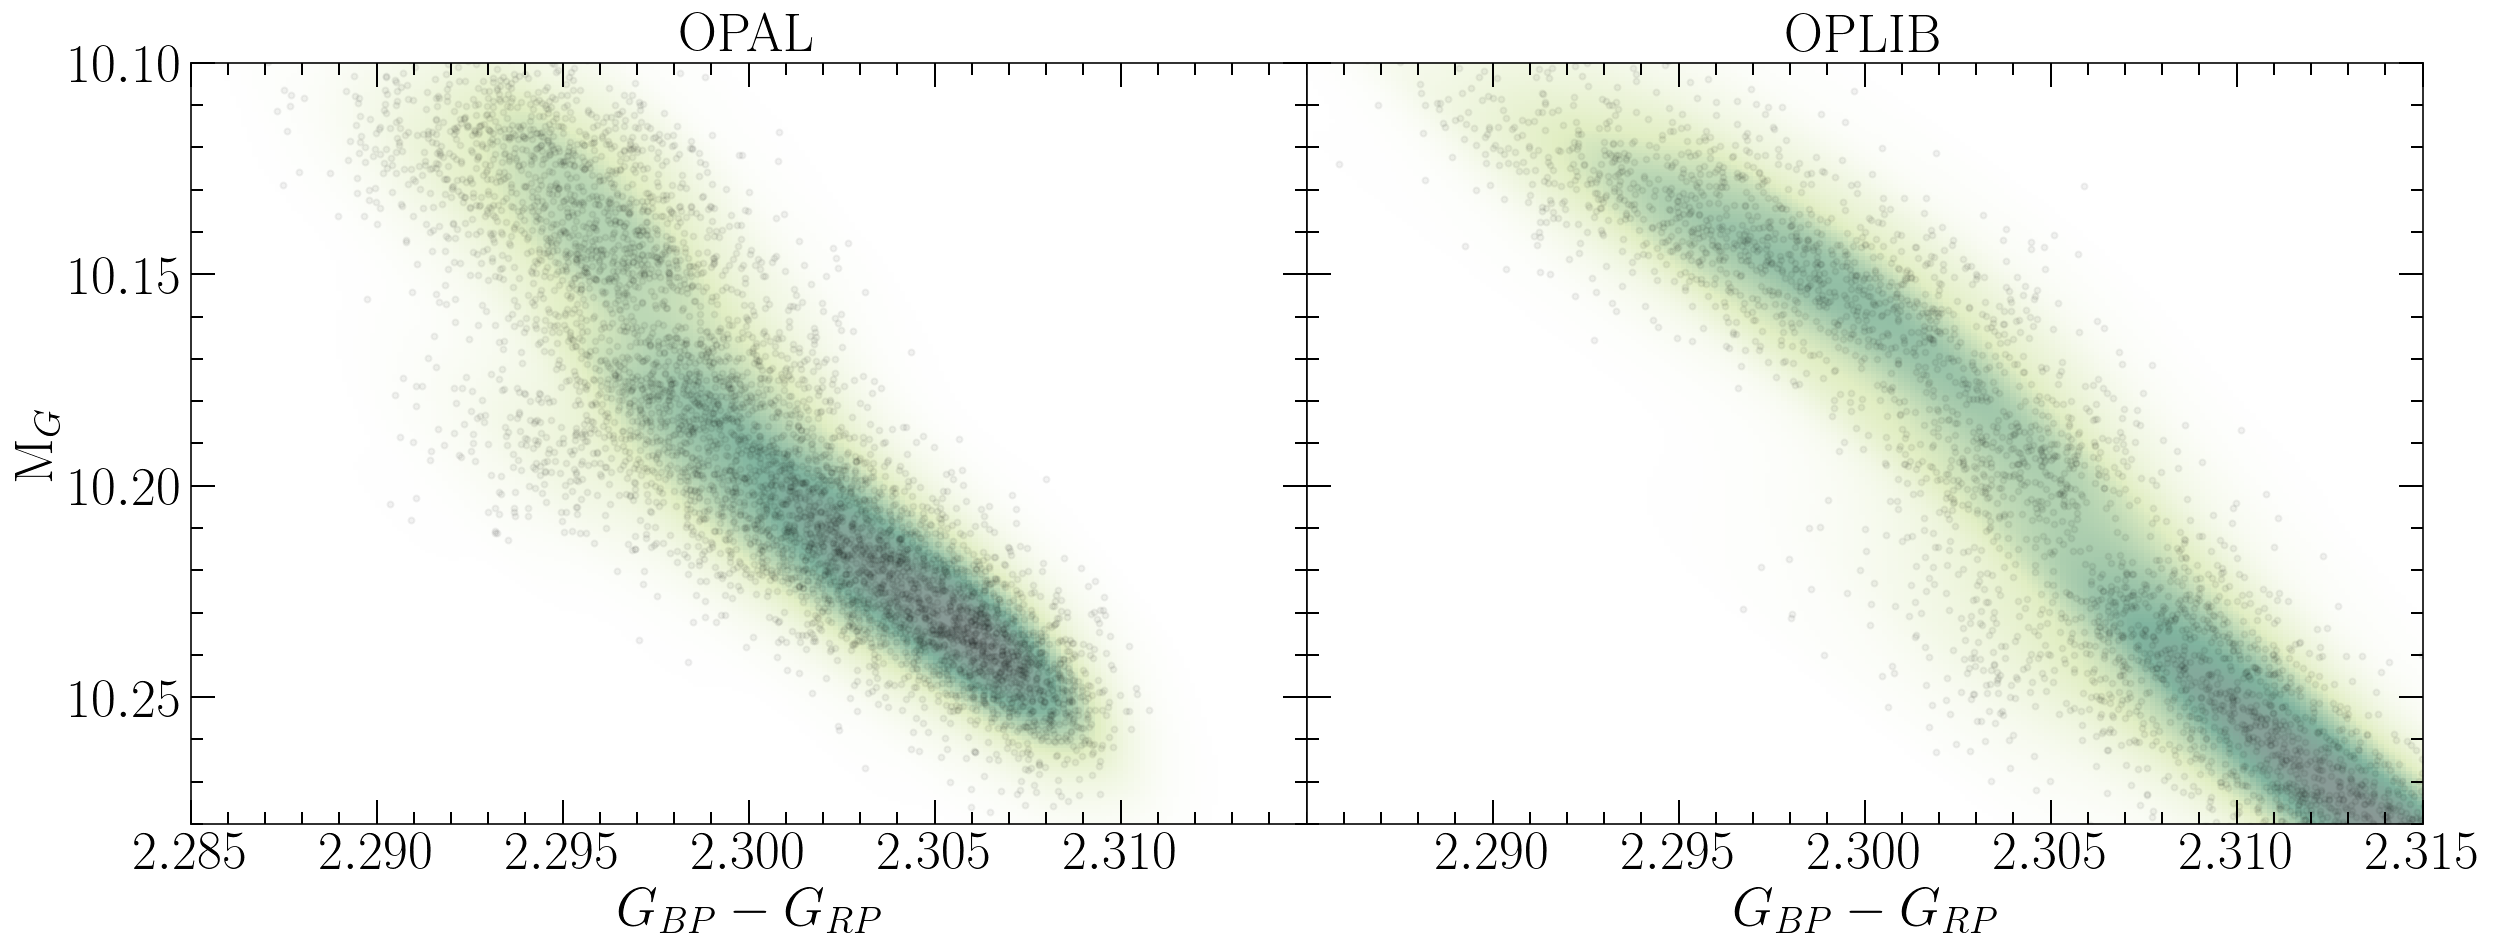

In [9]:
bounds = ((2.285, 2.315),(10.1, 10.28))
n = 5000
fig, axs = plt.subplots(1, 2, figsize=(20,7))
kde = plot_CMD(data_opal[6][n], ax=axs[0],kde_b=True,po=True,poalpha=0.05,bounds=bounds,kdealpha=0.5)
plot_CMD(data_tops[6][n], ax=axs[1],kde_b=True,fmt="k.",po=True,poalpha=0.05,bounds=bounds,kdealpha=0.5)

axs[0].set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)
axs[1].set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)
axs[0].set_ylabel("M$_{G}$", fontsize=27)

axs[1].set_yticklabels([]);

axs[0].set_title("OPAL", fontsize=27)
axs[1].set_title("OPLIB", fontsize=27)
    
for ax in axs:
    ax.tick_params('both', length=12, width=1, which='major')
    ax.tick_params('both', length=6, width=1, which='minor')
    ax.tick_params(axis='x',labelsize=27)
    ax.tick_params(axis='y',labelsize=27)
    
axs[0].set_xticks(axs[0].get_xticks()[:-1])
axs[1].set_xticks(axs[1].get_xticks()[1:])
    
axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("Figures/OPALOPLIB_popsynth_comp_clampedTime.pdf", bbox_inches="tight")

Peak at pe=10.17718 with prominence of po=0.17795
Peak at pe=10.21218 with prominence of po=0.32097


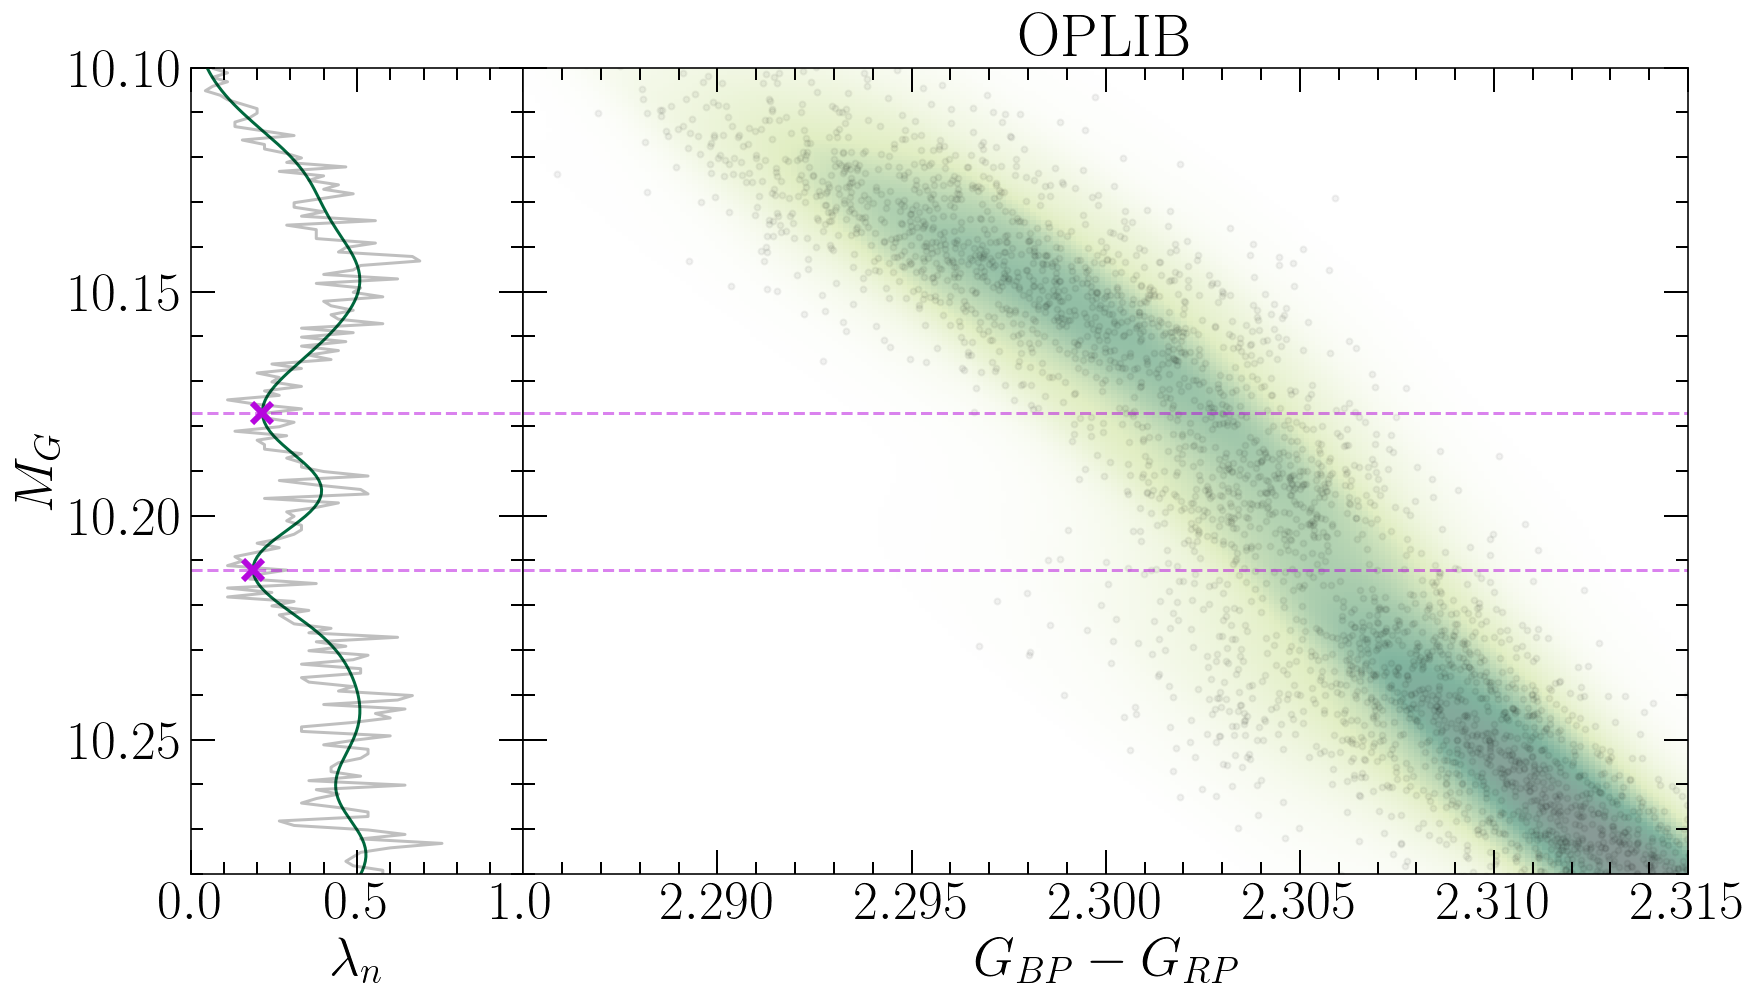

In [10]:
bounds = ((2.285, 2.315),(10.1, 10.28))
binSize = 0.001
data_source = data_tops
x = data_source[6.0][n][:, 7] - data_source[6.0][n][:, 8]
y = data_source[6.0][n][:, 6]
data_array = np.vstack([x, y])

density, center = get_bin_density(data_array, binSize, axis=1)

order = 6
sampleRate = 1/binSize
cutoff = sampleRate/25

normalizedDensity = density/np.max(density)

filteredDensity = butter_lowpass_filter(normalizedDensity, cutoff, sampleRate, order)

peaks, properties = signal.find_peaks(-filteredDensity, prominence=0.1)

fig = plt.figure(figsize=(13,7))
gs = fig.add_gridspec(1, 2, width_ratios=(2, 7), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_CMD(data_source[6][n], ax=ax2,kde_b=True,po=True,poalpha=0.05,bounds=bounds,kdealpha=0.5)

ax2.invert_yaxis()

ax1.plot(filteredDensity, center, color=colorscheme.DartmouthGreen)
ax1.plot(normalizedDensity, center, alpha=0.25, color=colorscheme.Black)

ax1.plot(filteredDensity[peaks], center[peaks], 'x', color=colorscheme.Violet, markersize=10, markeredgewidth=3)

ax2bounds = ax2.get_ylim()
ax1.set_ylim(ax2bounds)

for gap in center[peaks]:
    ax2.axhline(gap, linestyle='dashed', color=colorscheme.Violet, alpha=0.5)
    ax1.axhline(gap, linestyle='dashed', color=colorscheme.Violet, alpha=0.5)



ax2.set_yticklabels([]);
ax1.set_xlim(0,1)
ax1.set_xticks([0,0.5,1])


ax1.set_ylabel("$M_{G}$", fontsize=27)
ax1.set_xlabel("$\lambda_{n}$", fontsize=27)
ax2.set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)

for ax in [ax1, ax2]:
    ax.tick_params('both', length=12, width=1, which='major')
    ax.tick_params('both', length=6, width=1, which='minor')
    ax.tick_params(axis='x',labelsize=27)
    ax.tick_params(axis='y',labelsize=27)
    
ax2.set_xticks(ax2.get_xticks()[1:]);

ax2.set_title("OPLIB", fontsize=30)

fig.savefig("Figures/OPLIB_Jao_locator.pdf", bbox_inches='tight')
for pe, po in zip(center[peaks], properties['prominences']):
    print(f"Peak at {pe=:0.5f} with prominence of {po=:0.5f}")

Peak at pe=10.15933 with prominence of po=0.15671


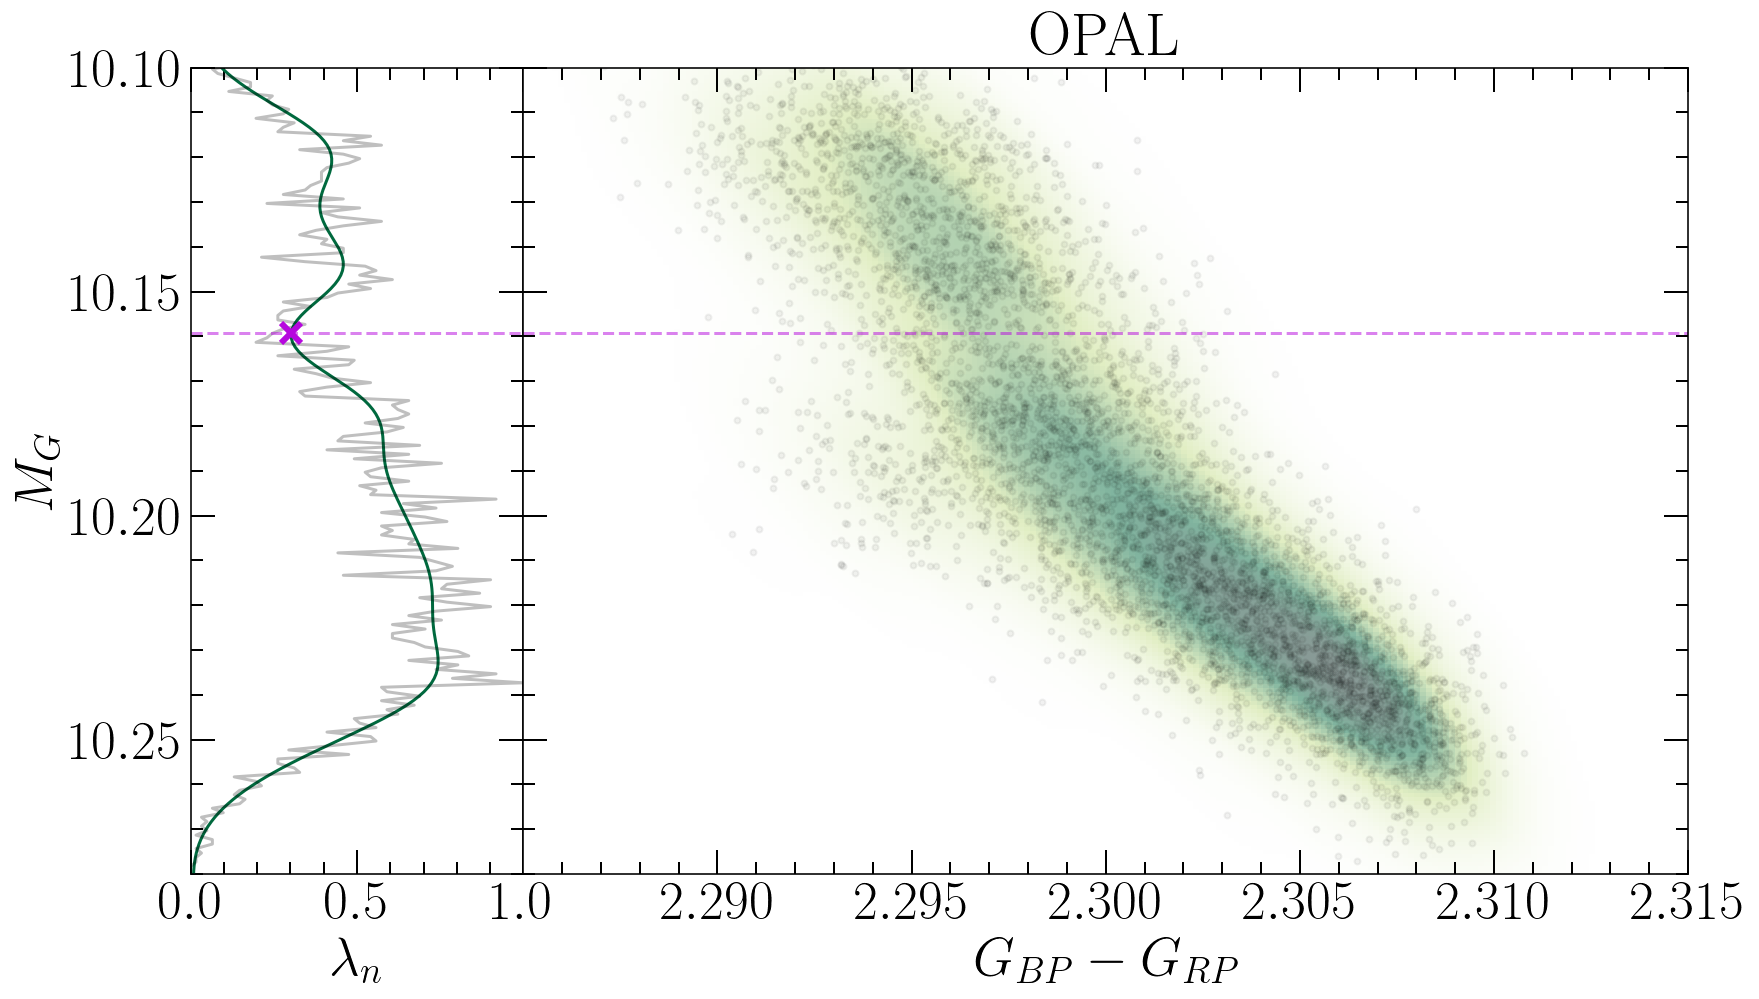

In [11]:
bounds = ((2.285, 2.315),(10.1, 10.28))
binSize = 0.001
data_source = data_opal
x = data_source[6.0][n][:, 7] - data_source[6.0][n][:, 8]
y = data_source[6.0][n][:, 6]
data_array = np.vstack([x, y])

density, center = get_bin_density(data_array, binSize, axis=1)

order = 6
sampleRate = 1/binSize
cutoff = sampleRate/25

normalizedDensity = density/np.max(density)

filteredDensity = butter_lowpass_filter(normalizedDensity, cutoff, sampleRate, order)

peaks, properties = signal.find_peaks(-filteredDensity, prominence=0.1)

fig = plt.figure(figsize=(13,7))
gs = fig.add_gridspec(1, 2, width_ratios=(2, 7), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_CMD(data_source[6][n], ax=ax2,kde_b=True,po=True,poalpha=0.05,bounds=bounds,kdealpha=0.5)

ax2.invert_yaxis()

ax1.plot(filteredDensity, center, color=colorscheme.DartmouthGreen)
ax1.plot(normalizedDensity, center, alpha=0.25, color=colorscheme.Black)

ax1.plot(filteredDensity[peaks], center[peaks], 'x', color=colorscheme.Violet, markersize=10, markeredgewidth=3)

ax2bounds = ax2.get_ylim()
ax1.set_ylim(ax2bounds)

for gap in center[peaks]:
    ax2.axhline(gap, linestyle='dashed', color=colorscheme.Violet, alpha=0.5)
    ax1.axhline(gap, linestyle='dashed', color=colorscheme.Violet, alpha=0.5)



ax2.set_yticklabels([]);
ax1.set_xlim(0,1)
ax1.set_xticks([0,0.5,1])


ax1.set_ylabel("$M_{G}$", fontsize=27)
ax1.set_xlabel("$\lambda_{n}$", fontsize=27)
ax2.set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)

for ax in [ax1, ax2]:
    ax.tick_params('both', length=12, width=1, which='major')
    ax.tick_params('both', length=6, width=1, which='minor')
    ax.tick_params(axis='x',labelsize=27)
    ax.tick_params(axis='y',labelsize=27)
    
ax2.set_xticks(ax2.get_xticks()[1:]);
ax2.set_title("OPAL", fontsize=30)

fig.savefig("Figures/OPAL_Jao_locator.pdf", bbox_inches='tight')

for pe, po in zip(center[peaks], properties['prominences']):
    print(f"Peak at {pe=:0.5f} with prominence of {po=:0.5f}")

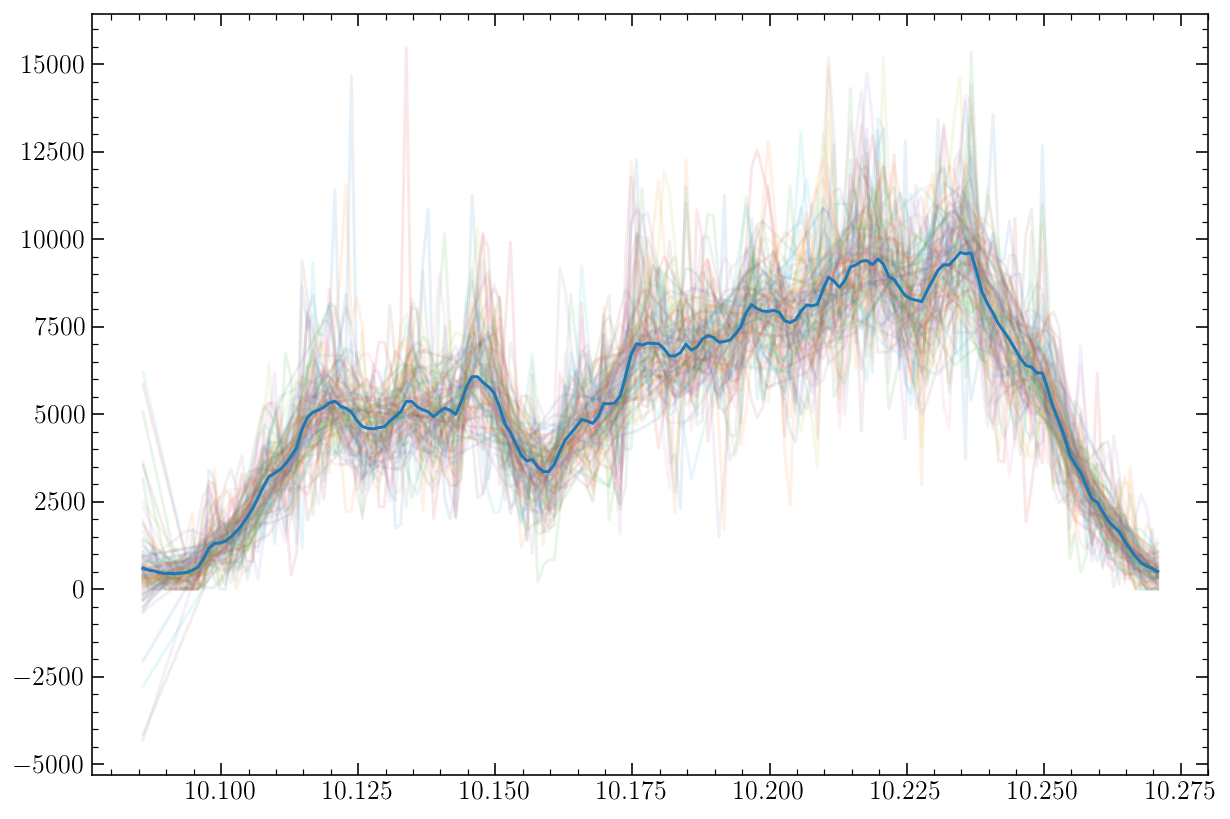

In [208]:
N = 100
binSize = np.linspace(0.001, 0.01, N)
indicies = np.random.choice(indicies, size=(N,1000))
data_source = data_opal
x = data_source[6.0][n][:, 7] - data_source[6.0][n][:, 8]
y = data_source[6.0][n][:, 6]
data_array = np.vstack([x, y])
data_sample = data_array[:, sample]
_, X = get_bin_density(data_sample, binSize.min(), axis=1)
fig, ax = plt.subplots(1, 1)
indicies = range(data_array.shape[1])
mean = np.zeros_like(X)
for sample, bs in zip(np.random.choice(indicies, size=(N,1000)), binSize):
    data_sample = data_array[:, sample]
    # ax.plot(data_sample[0], data_sample[1], 'o')
    density, center = get_bin_density(data_sample, bs, axis=1)
    # ax.plot(center, density)
    f = interp1d(center, density, bounds_error=False, fill_value='extrapolate')
    uD = f(X)
    ax.plot(X, uD, alpha=0.1)
    mean += uD
mean = mean/N
ax.plot(X, mean)
    
# ax.invert_yaxis()

/tmp/ipykernel_27795/1474056858.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(age, radius, convectiveMask.T, hatch='/', cmap=mpl.cm.get_cmap('binary_r'))


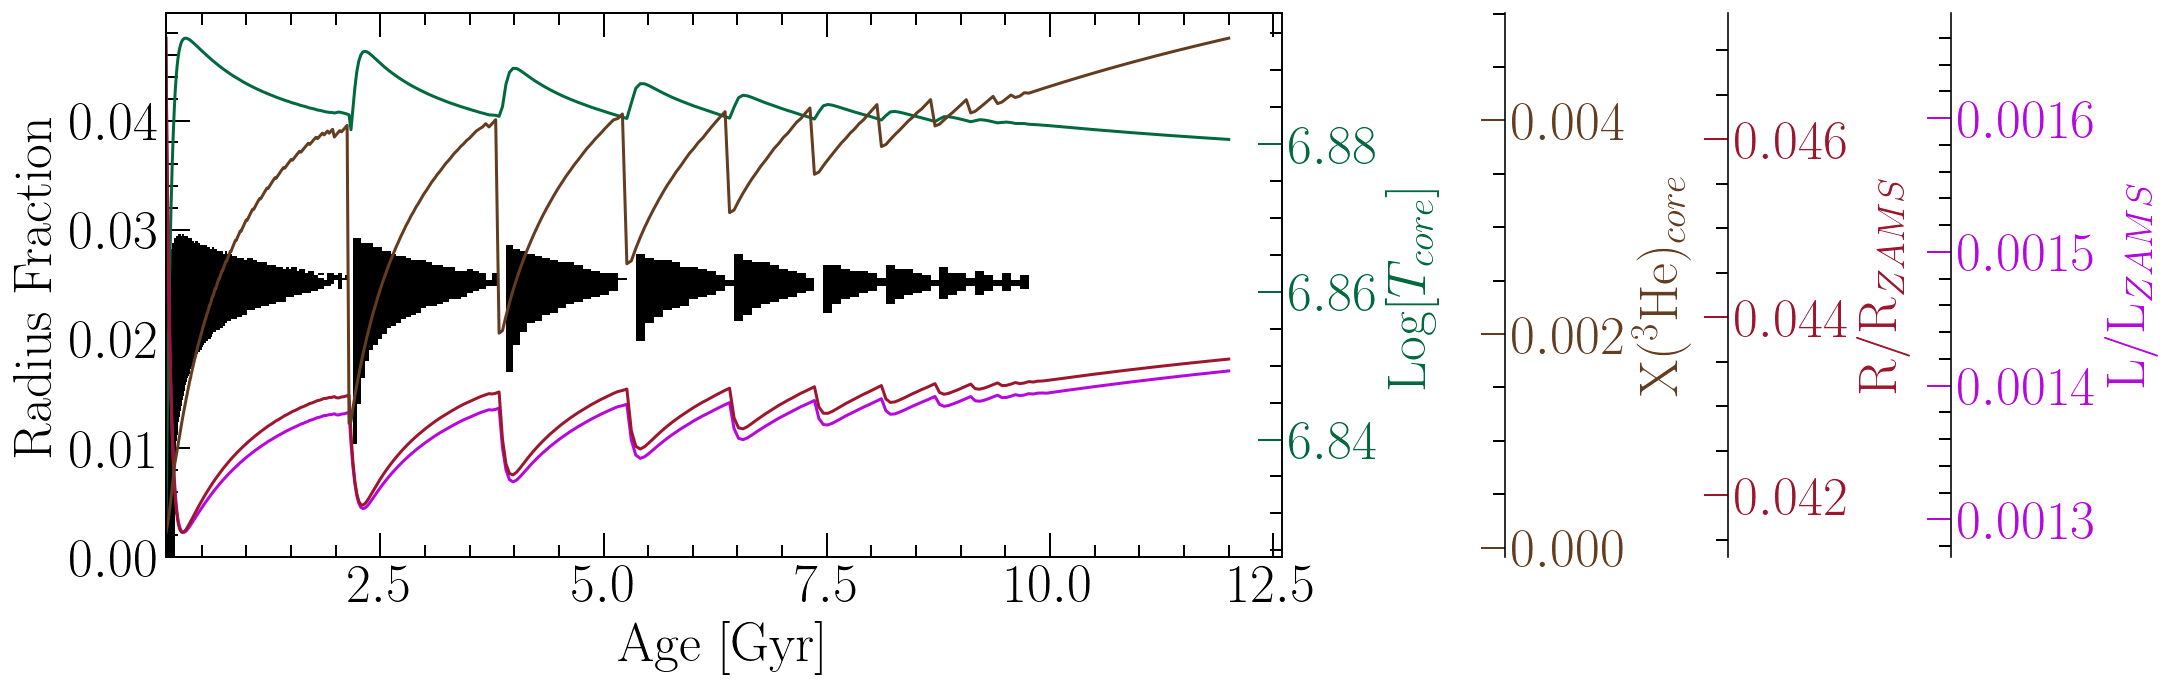

In [27]:
model, tdir = load_model("modelOfInterest.dsep")
mkKippenhan(model)

In [28]:
OPALModel, OPALtdir = load_model("OPALSSCM.dsep")
OPLIBModel, OPLIBtdir = load_model("OPLIBSSCM.dsep")

fig, ax = plt.subplots(1, 1, figsize=(15, 13))

ax.plot(10**OPALModel.iso()['Log_T'].values, OPALModel.iso()['Log_L'], color='black', label='OPAL')
ax.plot(10**OPLIBModel.iso()['Log_T'].values, OPLIBModel.iso()['Log_L'], color='red', linestyle='dashed', label='OPLIB')

ax.set_xlabel('T$_{eff}$ [K]', fontsize=25)
ax.set_ylabel('Log[L/L$_{\odot}$]', fontsize=25)
ax.legend(loc='best', fontsize=25, frameon=False)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params('both', length=12, width=2, which='major')
ax.tick_params('both', length=8, width=1, which='minor')

ax.axes.invert_xaxis()
fig.savefig('Figures/HRDiagramOPALvsOPLIB_SCCM.pdf', bbox_inches='tight')

KeyError: 31